In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Dropout, MaxPool2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Buat fungsi untuk nge load gambar

In [2]:
def load_images(image_path):
    files = np.array(os.listdir(image_path))
    
    images = []
    for image in tqdm(files):
        # Read image
        image = cv2.imread(image_path + image)
        # Resize image to 200x200 px
        image = cv2.resize(image, dsize=(200,200))
        images.append(image)
        
    images = np.array(images)
    
    return images

# Load data train dan test

In [3]:
normal_train = load_images('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/')
pneu_train = load_images ('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/')

normal_test = load_images('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/')
pneu_test = load_images ('../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/')

100%|██████████| 390/390 [00:05<00:00, 71.72it/s]


In [4]:
print('Shape\t\t\t: (jumlah gambar, tinggi, lebar, RGB)')

print('Normal train shape\t:', normal_train.shape)
print('Pneumonia train shape\t:', pneu_train.shape)

print('Normal test shape\t:', normal_test.shape)
print('Pneumonia test shape\t:', pneu_test.shape)

Shape			: (jumlah gambar, tinggi, lebar, RGB)
Normal train shape	: (1341, 200, 200, 3)
Pneumonia train shape	: (3875, 200, 200, 3)
Normal test shape	: (234, 200, 200, 3)
Pneumonia test shape	: (390, 200, 200, 3)


# Tampilkan beberapa data

X-ray orang normal


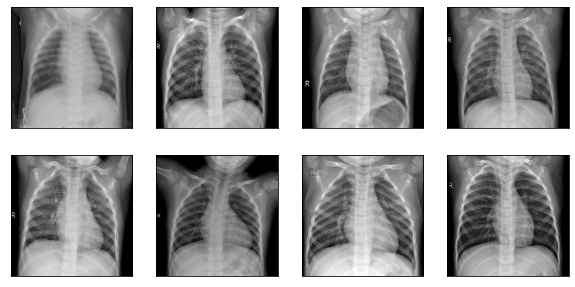

In [5]:
print('X-ray orang normal')
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=False,
                         sharey=True, figsize=(10, 5))
index = 10
for i in range(2):
    for j in range(4):
        axes[i,j].imshow(normal_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

X-ray orang yang kena pneumonia


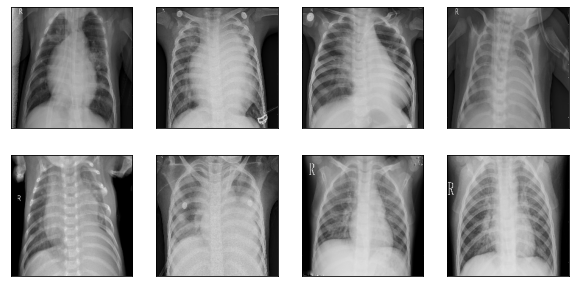

In [6]:
print('X-ray orang yang kena pneumonia')
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=False,
                         sharey=True, figsize=(10, 5))
index = 100
for i in range(2):
    for j in range(4):
        axes[i,j].imshow(pneu_train[index])
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

# Masukin data train dan test ke 1 array (data X)

In [7]:
X_train = np.vstack((normal_train, pneu_train))
X_test = np.vstack((normal_test, pneu_test))

print('X_train.shape\t:', X_train.shape)
print('X_test.shape\t:', X_test.shape)

X_train.shape	: (5216, 200, 200, 3)
X_test.shape	: (624, 200, 200, 3)


# Buat label (data y)
0 = normal,
1 = pneumonia

In [8]:
y_train = np.append([0] * normal_train.shape[0], [1] * pneu_train.shape[0])
y_test = np.append([0] * normal_test.shape[0], [1] * pneu_test.shape[0])

print('y_train.shape\t:', y_train.shape)
print('y_test.shape\t:', y_test.shape)

y_train.shape	: (5216,)
y_test.shape	: (624,)


# Shuffling data

In [9]:
# Masukkan ke dalam 1 array
train = np.array(list(zip(X_train, y_train)))
test = np.array(list(zip(X_test, y_test)))

# Di-shuffle
np.random.shuffle(train)
np.random.shuffle(test)

# X sama y-nya dipisah lagi (train)
X_train, y_train = zip(*train)
X_train = np.array(X_train)
y_train = np.array(y_train)

# X sama y-nya dipisah lagi (test)
X_test, y_test = zip(*test)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Data augmentation

In [10]:
datagen = ImageDataGenerator(
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

In [11]:
datagen.fit(X_train)

# Buat neural networknya (CNN)

In [12]:
X_train.shape

(5216, 200, 200, 3)

In [13]:
input1 = Input(shape=(200, 200, 3))

In [14]:
cnn = Conv2D(16, (3, 3), activation='relu', 
             strides=(1, 1), padding='same')(input1)
cnn = Conv2D(32, (3, 3), activation='relu', 
             strides=(1, 1), padding='same')(cnn)
cnn = MaxPool2D((2, 2))(cnn)
cnn = Flatten()(cnn)

In [15]:
cnn = Dropout(0.5)(cnn)
cnn = Dense(100, activation='relu')(cnn)
cnn = Dropout(0.5)(cnn)
cnn = Dense(50, activation='relu')(cnn)
output1 = Dense(1, activation='sigmoid')(cnn)

In [16]:
model = Model(inputs=input1, outputs=output1)

In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 320000)            0         
_________________________________________________________________
dropout (Dropout)            (None, 320000)            0         
_________________________________________________________________
dense (Dense)                (None, 100)              

In [18]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', metrics=['acc'])

In [19]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_acc', 
                             mode='max', verbose=1, 
                             save_best_only=True, period=1)

# Mulai training

In [20]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=32), 
                              epochs=30, shuffle=True, 
                              validation_data=(X_test, y_test), 
                              callbacks=[checkpoint])

Epoch 1/30
163/163 [==============================] - ETA: 0s - loss: 55.7449 - acc: 0.7343
Epoch 00001: val_acc improved from -inf to 0.76282, saving model to model.h5
163/163 [==============================] - 45s 276ms/step - loss: 55.7449 - acc: 0.7343 - val_loss: 0.9236 - val_acc: 0.7628
Epoch 2/30
163/163 [==============================] - ETA: 0s - loss: 0.3713 - acc: 0.8255
Epoch 00002: val_acc did not improve from 0.76282
163/163 [==============================] - 44s 272ms/step - loss: 0.3713 - acc: 0.8255 - val_loss: 1.1805 - val_acc: 0.7340
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.3526 - acc: 0.8336
Epoch 00003: val_acc did not improve from 0.76282
163/163 [==============================] - 45s 278ms/step - loss: 0.3526 - acc: 0.8336 - val_loss: 1.0754 - val_acc: 0.7019
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.3565 - acc: 0.8439
Epoch 00004: val_acc did not improve from 0.76282
163/163 [==========================

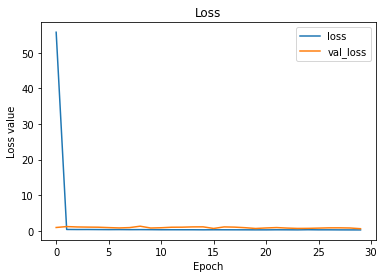

In [21]:
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

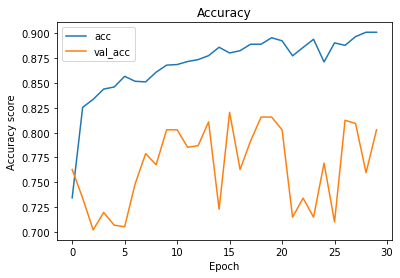

In [22]:
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy score')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.show()

In [23]:
model = load_model('./model.h5')

# Buat confusion matrix

In [24]:
def create_confusion_matrix(image_to_predict, actual_labels):
    test_predictions = np.round(model.predict(image_to_predict))

    cm = confusion_matrix(actual_labels, test_predictions)

    plt.figure(figsize=(6,6))
    plt.title('Confusion matrix')
    sns.heatmap(cm, annot=True, fmt='d', 
                cmap=plt.cm.Blues, cbar=False, annot_kws={'size':14})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

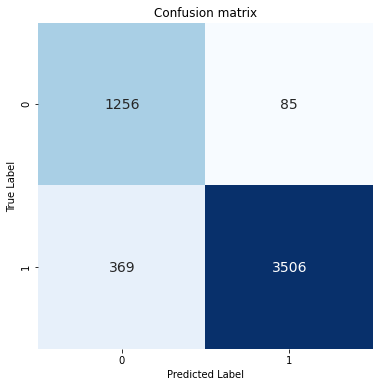

In [25]:
create_confusion_matrix(X_train, y_train)

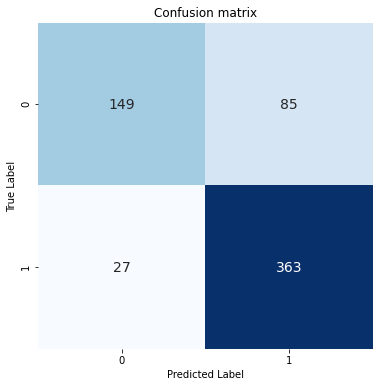

In [26]:
create_confusion_matrix(X_test, y_test)

# Test secara manual (pakai data di folder val)

In [27]:
manual_test_normal = load_images('../input/chest-xray-pneumonia/chest_xray/val/NORMAL/')
manual_test_pneu = load_images('../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/')

100%|██████████| 8/8 [00:00<00:00, 66.00it/s]


In [28]:
manual_pred_normal = np.round(model.predict(manual_test_normal))
manual_pred_pneu = np.round(model.predict(manual_test_pneu))

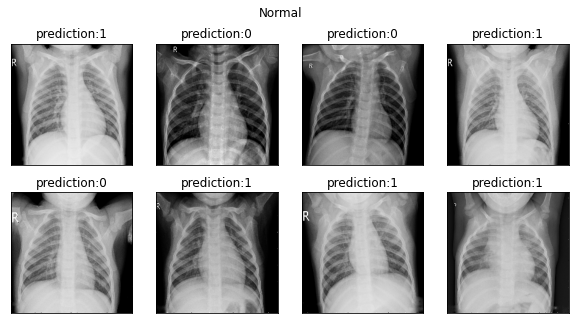

In [29]:
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=False,
                         sharey=True, figsize=(10, 5))
plt.suptitle('Normal')
index = 0
for i in range(2):
    for j in range(4):
        axes[i,j].set_title('prediction:' + str(int(manual_pred_normal[index][0])))
        axes[i,j].imshow(manual_test_normal[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()

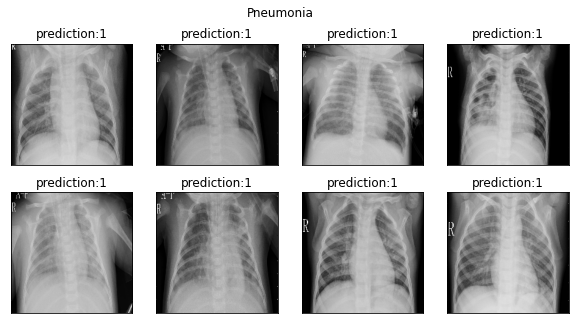

In [30]:
fig, axes = plt.subplots(ncols=4, nrows=2, sharex=False,
                         sharey=True, figsize=(10, 5))
plt.suptitle('Pneumonia')
index = 0
for i in range(2):
    for j in range(4):
        axes[i,j].set_title('prediction:' + str(int(manual_pred_pneu[index][0])))
        axes[i,j].imshow(manual_test_pneu[index], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        index += 1
plt.show()